In [1]:
import os
import sys
sys.path.append("../../src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import joblib
from util import *

In [2]:
BAG_META_PATH = "./../../data/raw/bag_meta.csv"
BAG_DATA_PATH = "./../../data/curated/bag_data.csv"
CROSS_VALID_MODELS_PATH = "./../../model/cross-validation/"

bag_meta = pd.read_csv(BAG_META_PATH).iloc[:, 1:]
bag_data = pd.read_csv(BAG_DATA_PATH).iloc[:, 1:]

In [3]:
N_PARTITIONS = 5
N_TREES = 1000

# Determining how to split dataset0 into 5 folds for Cross Validation
Note: The split has to occur on a **gene level** so that we can estimate how the model will perform when it encounters data from unseen genes. We try to create folds that have similar number of bags

,gene_id,n_bags
0,ENSG00000128050,274
1,ENSG00000110321,253
2,ENSG00000164924,250
3,ENSG00000141367,230
4,ENSG00000138434,229
...,...,...
3847,ENSG00000106462,1
3848,ENSG00000106605,1
3849,ENSG00000107719,1
3850,ENSG00000168273,1


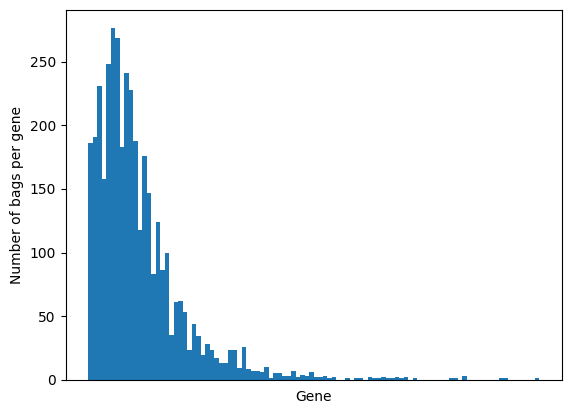

In [4]:
# Generating the number of reads for each gene
gene_count = bag_meta.gene_id.value_counts().reset_index().rename(columns = {"index" : "gene_id", "gene_id" : "n_bags"})
display(gene_count)

plt.hist(gene_count.n_bags.to_list(), bins = 100)
plt.ylabel("Number of bags per gene")
plt.xlabel("Gene")
plt.xticks([])
plt.show()

In [5]:
def generate_k_folds(input_list, k = 5):
    sorted_list = sorted(input_list, reverse=True, key = lambda entry: entry[1])
    partition_indices = [[] for _ in range(k)]
    partitions = [[] for _ in range(k)]
    sums = [0] * k

    for entry in sorted_list:
        gene, num = entry
        min_sum_index = sums.index(min(sums))
        partitions[min_sum_index].append(num)
        partition_indices[min_sum_index].append(gene)
        sums[min_sum_index] += num

    return partitions, partition_indices

def flatten_2d(matrix):
    return [item for sublist in matrix for item in sublist]

In [6]:
partitioned_n_bags, partitioned_genes = generate_k_folds(gene_count.values)

# Check if the partition has been done correctly (i.e. Every gene is in exactly one partition)
if sorted(flatten_2d(partitioned_n_bags)) == sorted(gene_count.n_bags):
    print("Partition completed")
else:
    print("Partition error")

for i, gene_list in enumerate(partitioned_genes):
    print(f'Partition {i + 1} read count: {gene_count.loc[gene_count.gene_id.isin(gene_list), "n_bags"].sum()} bags')

Partition completed
Partition 1 read count: 24368 bags
Partition 2 read count: 24368 bags
Partition 3 read count: 24368 bags
Partition 4 read count: 24367 bags
Partition 5 read count: 24367 bags


In [7]:
def merge_partitions(partitioned_genes):
    """Returns the bag data of the bags whose gene is in partitioned_genes, and the number of reads in the merged partition"""
    partitioned_genes_flattened = flatten_2d(partitioned_genes)
    valid_bag_ids = bag_meta.loc[bag_meta.gene_id.isin(partitioned_genes_flattened), "bag_id"].tolist()
    return bag_data.loc[bag_data.bag_id.isin(valid_bag_ids), :]

def get_merged_dataset(test_fold_id):
    if test_fold_id < 0 or test_fold_id >= N_PARTITIONS:
        raise Exception(f"Value for test_fold_id has to be between 0 and {N_PARTITIONS - 1} (inclusive). Received: {test_fold_id}")
    train_data = merge_partitions(partitioned_genes[:test_fold_id] + partitioned_genes[(test_fold_id + 1) : ]).reset_index(drop=True)
    test_data = merge_partitions([partitioned_genes[test_fold_id]]).reset_index(drop = True)
    return train_data, test_data

# Training RF Model

In [8]:
## Generate the cross-validation models (Note: This will take hours to run)

# for i in range(N_PARTITIONS):
#     train_data, test_data = get_merged_dataset(i)
#     rf = RandomForestRegressor(n_estimators = N_TREES, random_state = 0, verbose=2, n_jobs = 8)
#     rf.fit(train_data.iloc[:,2:], train_data.iloc[:,1])
#     joblib.dump(rf, f"{CROSS_VALID_MODELS_PATH}/model{i}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.1s finished


AUCOC: 0.9804955259774955


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


AUCOC: 0.9830708271870904


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


AUCOC: 0.9740655927096313


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished


AUCOC: 0.9855716361545337


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.2s finished


AUCOC: 0.9752660056823059
Average AUROC: 0.97969


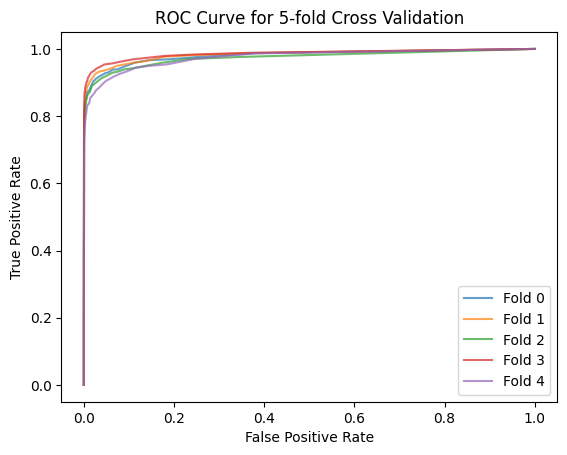

In [9]:
auroc_list = []
for i in range(N_PARTITIONS):
    train_data, test_data = get_merged_dataset(i)
    model_name = f"model{i}"
    rf = joblib.load(f"{CROSS_VALID_MODELS_PATH}/model{i}")
    X = test_data.iloc[:, 2:]
    y = test_data.iloc[:, 1]
    tpr, fpr, auroc = generate_roc_curve(rf, X, y)
    auroc_list.append(auroc)
    plt.plot(fpr, tpr, label = f"Fold {i}", alpha = 0.7)
    print(f"AUCOC: {auroc}")
print(f"Average AUROC: {round(np.mean(auroc_list), 5)}")
plt.title(f"ROC Curve for {N_PARTITIONS}-fold Cross Validation")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()